# Analysis of Processed and Filtered Data

**Imports**

In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt

In [16]:
def create_plot_comparison(year,disaster_type):
    disaster_path = 'data/'+str(year)+'_'+disaster_type+'_filtered_csv.bz2'
    climate_path = 'data/'+str(year)+'_'+disaster_type+'_climate_filtered_csv.bz2'
    
    disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
    climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')
    
    start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    start_climate, end_climate = climate_df.date.min(), climate_df.date.max()
    
    print(
        "Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print(
        "Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + 'Storm',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    _, bins, _ = plt.hist(climate_df.date, bins=60, alpha=0.4, label='Climate Talk', log=True)
    plt.hist(disaster_df.date, bins=bins, alpha=0.7, label=type_to_str[disaster_type]+'Talk')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [17]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-05-20 --- 2015-06-09
Climate Dates:  2015-04-29 --- 2015-06-20


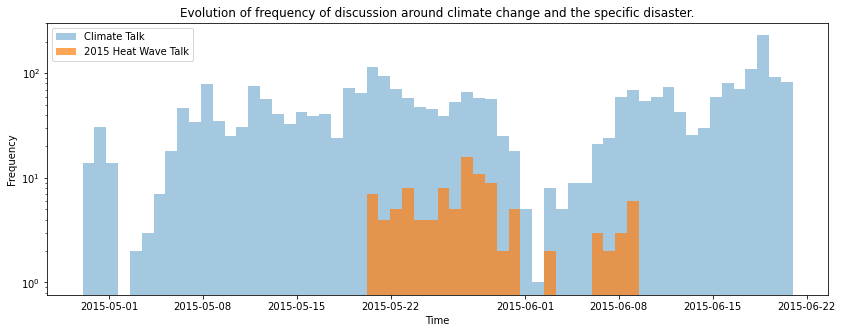

In [18]:
create_plot_comparison(2015,disaster_type)

Disaster Dates: 2016-04-17 --- 2016-05-20
Climate Dates:  2016-03-11 --- 2016-05-20


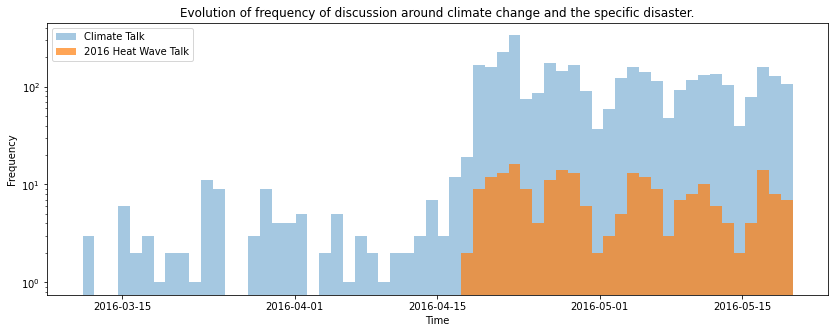

In [19]:
create_plot_comparison(2016,disaster_type)

Disaster Dates: 2017-01-31 --- 2017-02-24
Climate Dates:  2017-01-11 --- 2017-03-07


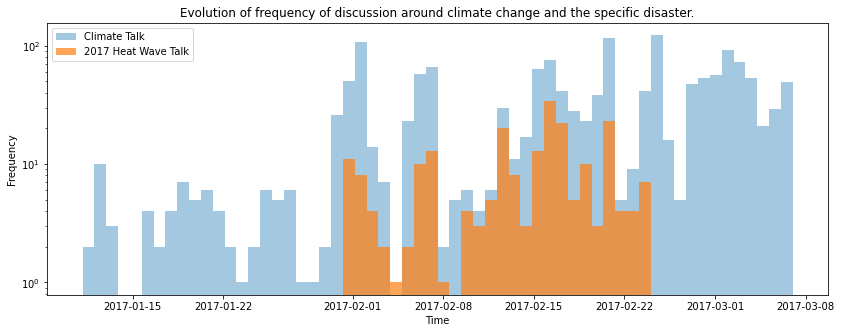

In [20]:
create_plot_comparison(2017,disaster_type)

Disaster Dates: 2018-07-01 --- 2018-08-03
Climate Dates:  2018-06-10 --- 2018-08-03


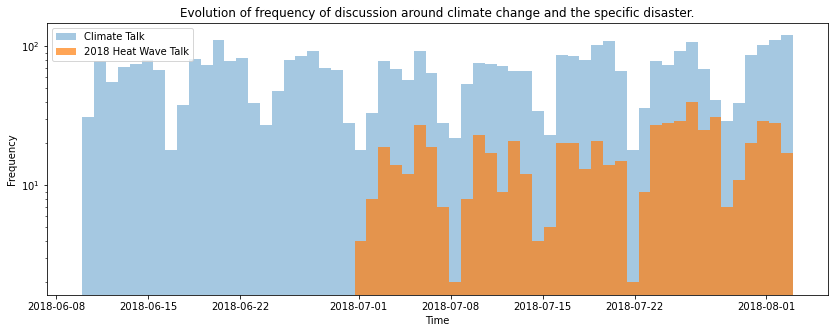

In [21]:
create_plot_comparison(2018,disaster_type)

Disaster Dates: 2019-07-19 --- 2019-08-05
Climate Dates:  2019-06-28 --- 2019-08-17


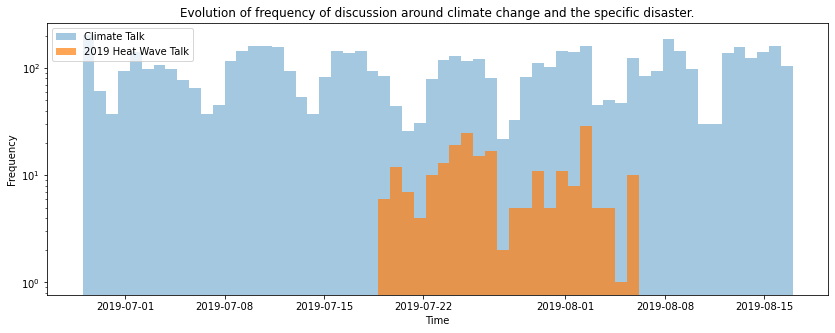

In [22]:
create_plot_comparison(2019,disaster_type)

Disaster Dates: 2019-09-02 --- 2020-01-31
Climate Dates:  2019-08-11 --- 2020-02-01


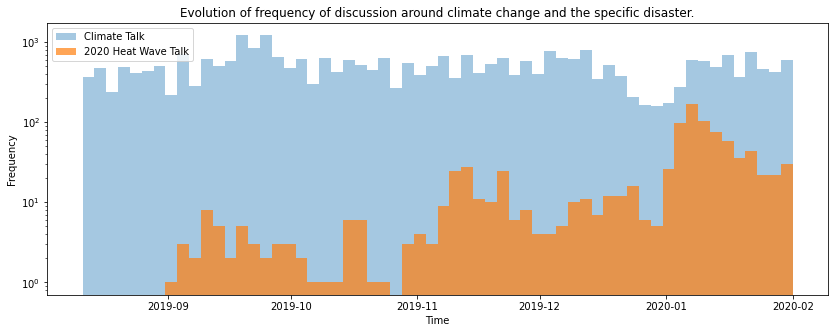

In [23]:
create_plot_comparison(2020,disaster_type)

**Original Code Here**

In [ ]:
YEAR = 2015
disaster_type = 'heat_wave'
disaster_path = 'data/'+str(YEAR)+'_'+disaster_type+'_filtered_csv.bz2'
climate_path = 'data/'+str(YEAR)+'_'+disaster_type+'_climate_filtered_csv.bz2'

In [ ]:
disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

In [ ]:
start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
start_climate, end_climate = climate_df.date.min(), climate_df.date.max()

In [ ]:
print("Disaster Dates: {} --- {}".format(start_disaster.strftime("%Y-%m-%d"), end_disaster.strftime("%Y-%m-%d")))
print("Climate Dates:  {} --- {}".format(start_climate.strftime("%Y-%m-%d"), end_climate.strftime("%Y-%m-%d")))

In [ ]:
fig = plt.gcf()
fig.set_size_inches(14, 5)
_, bins, _ = plt.hist(climate_df.date, bins=60, alpha=0.4, label='Climate Talk', log=True)
plt.hist(disaster_df.date, bins=bins, alpha=0.7, label='Disaster Talk')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
plt.legend(loc='upper left')
plt.show()